# RFM Method for Customer Segmentation

In [1]:
# Load data
import pandas as pd

df = pd.read_csv('dataCustomerRFM.csv')

In [2]:
df.head()

,Unnamed: 0,CustomerID,OrderDate,OrderID,Amount
0,0,b5731a6437,2019-07-09 23:56:44,f996cde8437b432580ae2d9c61b1470c,6249000.0
1,1,ba9a96efd7,2019-07-27 22:25:52,f9e7114611c34377b456774a05310bb5,816200.0
2,2,3bb7d08ac6,2019-09-30 06:29:39,f9f793f21dc24607a7ca4dae6c3abed3,77000.0
3,3,9cf0875c93,2019-07-31 16:12:51,83ccdf7eb8944a23b0ef706551c1a818,997000.0
4,4,b50d95bb37,2019-08-29 06:11:15,7fc8a7e9f6da4d76b9e562ce2ca58e97,380700.0


In [3]:
# Calculate Recency-Frequency-Monetary (RFM)
# 1. Recency
from datetime import datetime
# find the most recent order date
dfRecentOrder = pd.pivot_table(data=df,
                              index=['CustomerID'],
                              values=['OrderDate'],
                              aggfunc={'OrderDate':max}
                              )

dfRecentOrder.columns = ['RecentOrderDate']
df = pd.merge(df, dfRecentOrder.reset_index(), on = ['CustomerID'])
df['RecentOrderDate'] = df['RecentOrderDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['Recency'] = df['RecentOrderDate'].apply(lambda x: (datetime.now() - x).days)

In [4]:
# change Recency value to negative so that the value of the variable is covariant with the customer's rank
df['Recency'] = - df['Recency']

In [5]:
df['Recency'].head()

0   -1082
1   -1064
2   -1000
3   -1061
4   -1032
Name: Recency, dtype: int64

In [6]:
# 2. Frequency
dfFrequency = df.groupby('CustomerID').OrderID.nunique().to_frame()
dfFrequency.columns = ['Frequency']
df = pd.merge(df, dfFrequency.reset_index(), on = 'CustomerID')

In [7]:
df['Frequency'].head()

0    1
1    1
2    1
3    1
4    1
Name: Frequency, dtype: int64

In [8]:
# 3. Monetary
dfMonetary = df.groupby('CustomerID').Amount.sum().to_frame()
dfMonetary.columns = ['Monetary']
df = pd.merge(df, dfMonetary.reset_index(), on = 'CustomerID')

In [9]:
df['Monetary'].head()

0    6249000.0
1     816200.0
2      77000.0
3     997000.0
4     380700.0
Name: Monetary, dtype: float64

In [10]:
# Mapping the values of RFM fields with rank's threshold = 10
orderFrequencies = df['Frequency'].rank(method='first')
df['rFrequency'] = pd.qcut(orderFrequencies, 10, labels = False)
df[['rRecency', 'rMonetary']] = df[['Recency', 'Monetary']].apply(lambda x: pd.qcut(x, 10, labels = False))
df['rank'] = (df['rFrequency'] + df['rRecency'] + df['rMonetary'])/3
df['FinalRank'] = df['rank'].apply(int)

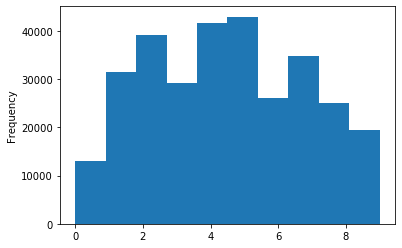

In [11]:
# Look at rank distribution of customer
import matplotlib.pyplot as plt

df['rank'].plot.hist(bins = 10)
plt.show()

In [12]:
df['Segment'] = 'Low'
df.loc[(df['rank'] < 7) & (df['rank'] >= 4), 'Segment'] = 'Normal'
df.loc[df['rank'] >= 7, 'Segment'] = 'VIP'

In [13]:
df['Segment'].head()

0    Low
1    Low
2    Low
3    Low
4    Low
Name: Segment, dtype: object

Text(0.5, 1.0, 'Percentage of customers by segment')

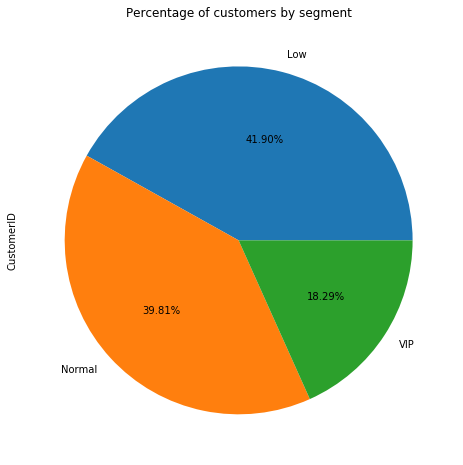

In [14]:
# Statistic the numbers of customers per segment
df.groupby('Segment').CustomerID.count().plot.pie(autopct = '%.2f%%', figsize = (8, 8))
plt.title('Percentage of customers by segment')

Text(0.5, 1.0, 'Ratio of sales by segment')

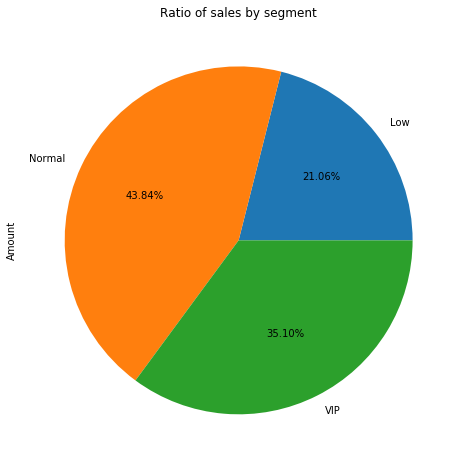

In [15]:
# Visualize by sales, purchase frequency, returning time of customer groups after segmenting.
df.groupby('Segment').Amount.sum().plot.pie(autopct = '%.2f%%', figsize = (8, 8))
plt.title('Ratio of sales by segment')

Text(0.5, 1.0, 'Ratio of sales by segment')

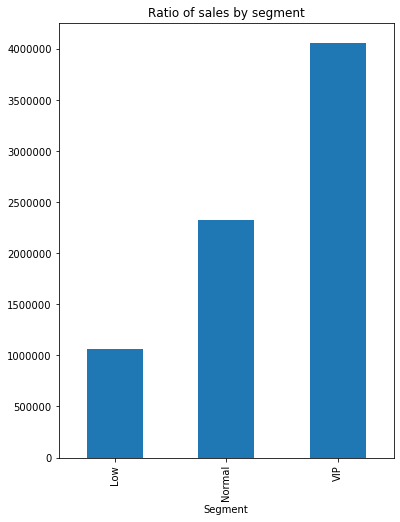

In [17]:
df.groupby('Segment').Amount.mean().plot.bar(figsize = (6, 8))
plt.title('Ratio of sales by segment')

Text(0.5, 1.0, 'Frequency of purchase by segment')

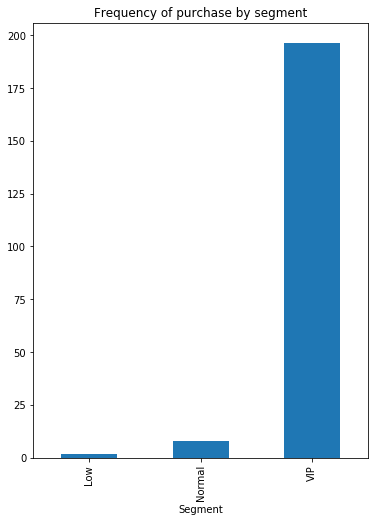

In [18]:
df.groupby('Segment').Frequency.mean().plot.bar(figsize = (6, 8))
plt.title('Frequency of purchase by segment')

Text(0.5, 1.0, 'The number of days of the last purchase by segment')

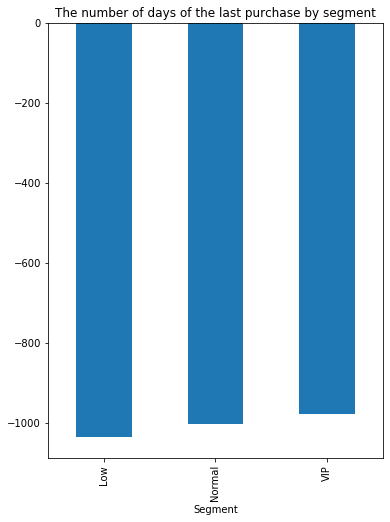

In [19]:
df.groupby('Segment').Recency.mean().plot.bar(figsize = (6, 8))
plt.title('The number of days of the last purchase by segment')

Conclusion:
    - We need to change our product policy so that they become more diverse and attractive to 3 ranked customers.
    - Increase the number of VIP customers to ensure the target of 20% VIP customers bringing 80% of sales.
    - Provide effective customer care and retention strategies.

# Clustering

In [20]:
df.head()

,Unnamed: 0,CustomerID,OrderDate,OrderID,Amount,RecentOrderDate,Recency,Frequency,Monetary,rFrequency,rRecency,rMonetary,rank,FinalRank,Segment
0,0,b5731a6437,2019-07-09 23:56:44,f996cde8437b432580ae2d9c61b1470c,6249000.0,2019-07-09 23:56:44,-1082,1,6249000.0,0,0,7,2.333333,2,Low
1,1,ba9a96efd7,2019-07-27 22:25:52,f9e7114611c34377b456774a05310bb5,816200.0,2019-07-27 22:25:52,-1064,1,816200.0,0,1,3,1.333333,1,Low
2,2,3bb7d08ac6,2019-09-30 06:29:39,f9f793f21dc24607a7ca4dae6c3abed3,77000.0,2019-09-30 06:29:39,-1000,1,77000.0,0,5,0,1.666667,1,Low
3,3,9cf0875c93,2019-07-31 16:12:51,83ccdf7eb8944a23b0ef706551c1a818,997000.0,2019-07-31 16:12:51,-1061,1,997000.0,0,1,3,1.333333,1,Low
4,4,b50d95bb37,2019-08-29 06:11:15,7fc8a7e9f6da4d76b9e562ce2ca58e97,380700.0,2019-08-29 06:11:15,-1032,1,380700.0,0,3,1,1.333333,1,Low


In [21]:
# Prepare data for K-means clustering
df_customers = pd.DataFrame()
df_customers['Recency'] = df['Recency']
df_customers['Frequency'] = df['Frequency']
df_customers['Monetary'] = df['Monetary'].values

In [22]:
df_customers.head()

,Recency,Frequency,Monetary
0,-1082,1,6249000.0
1,-1064,1,816200.0
2,-1000,1,77000.0
3,-1061,1,997000.0
4,-1032,1,380700.0


In [23]:
# Scaling data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_customers)
df_customers = scaler.transform(df_customers)

In [24]:
print(df_customers)

[[-2.02418687 -0.141086   -0.08195293]
 [-1.50321345 -0.141086   -0.08498161]
 [ 0.34913648 -0.141086   -0.0853937 ]
 ...
 [ 0.08864977 -0.141086   -0.08538088]
 [-0.43232364 -0.141086   -0.08538088]
 [ 0.69645209 -0.141086   -0.08411038]]


In [25]:
pd.DataFrame(df_customers).head()

,0,1,2
0,-2.024187,-0.141086,-0.081953
1,-1.503213,-0.141086,-0.084982
2,0.349136,-0.141086,-0.085394
3,-1.416385,-0.141086,-0.084881
4,-0.577038,-0.141086,-0.085224


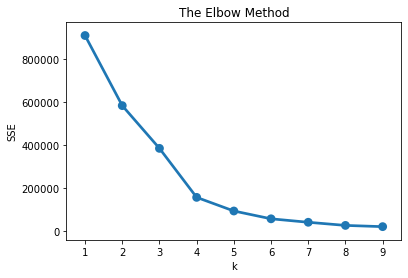

In [43]:
# Apply data into K-Means clustering
# Choose number of cluster by Elbow method
from sklearn.cluster import KMeans
import seaborn as sns

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [47]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df_customers)

KMeans(n_clusters=3, random_state=42)

In [50]:
df['Cluster'] = model.labels_
df.head()

,Unnamed: 0,CustomerID,OrderDate,OrderID,Amount,RecentOrderDate,Recency,Frequency,Monetary,rFrequency,rRecency,rMonetary,rank,FinalRank,Segment,Cluster
0,0,b5731a6437,2019-07-09 23:56:44,f996cde8437b432580ae2d9c61b1470c,6249000.0,2019-07-09 23:56:44,-1082,1,6249000.0,0,0,7,2.333333,2,Low,1
1,1,ba9a96efd7,2019-07-27 22:25:52,f9e7114611c34377b456774a05310bb5,816200.0,2019-07-27 22:25:52,-1064,1,816200.0,0,1,3,1.333333,1,Low,1
2,2,3bb7d08ac6,2019-09-30 06:29:39,f9f793f21dc24607a7ca4dae6c3abed3,77000.0,2019-09-30 06:29:39,-1000,1,77000.0,0,5,0,1.666667,1,Low,0
3,3,9cf0875c93,2019-07-31 16:12:51,83ccdf7eb8944a23b0ef706551c1a818,997000.0,2019-07-31 16:12:51,-1061,1,997000.0,0,1,3,1.333333,1,Low,1
4,4,b50d95bb37,2019-08-29 06:11:15,7fc8a7e9f6da4d76b9e562ce2ca58e97,380700.0,2019-08-29 06:11:15,-1032,1,380700.0,0,3,1,1.333333,1,Low,1


In [51]:
df.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,-988.60,18.16,2.277214e+08
1,-1050.99,6.76,1.818981e+07
2,-970.00,2807.00,7.591467e+08


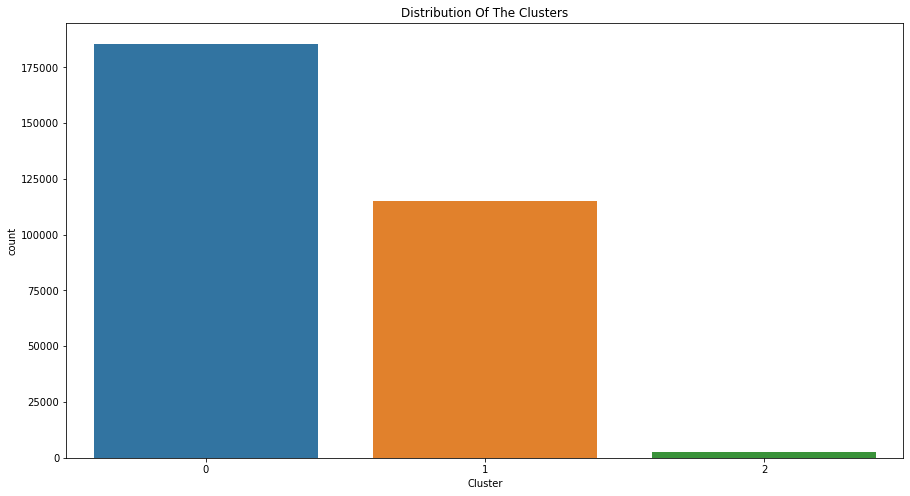

In [52]:
# Plotting the count of clusters
import matplotlib.cm as cmap
from matplotlib import colors

plt.figure(figsize=(15,8))
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']
pl = sns.countplot(x=df['Cluster'], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()